Categorias: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


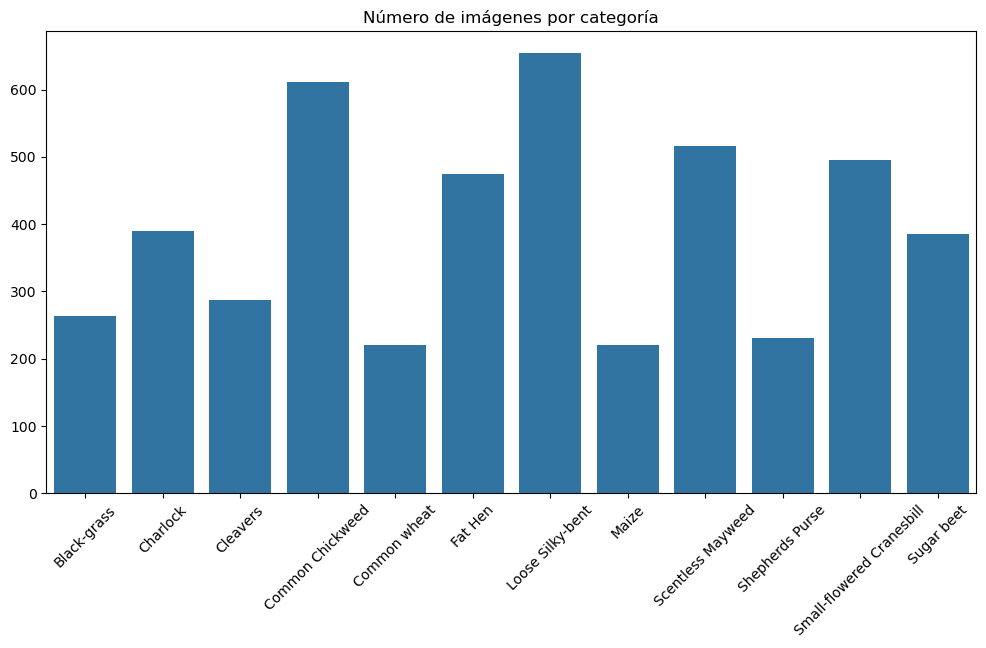

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Ubiación de datos
train_dir = r'C:\Users\esco1\plant-seedlings-classification\train'
test_dir = r'C:\Users\esco1\plant-seedlings-classification\test'

#
categorias = os.listdir(train_dir)
print(f"Categorias: {categorias}")

category_counts = {}
for category in categorias:
    category_dir = os.path.join(train_dir, category)
    count = len(os.listdir(category_dir))
    category_counts[category] = count

plt.figure(figsize=(12, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title('Número de imágenes por categoría')
plt.xticks(rotation=45)
plt.show()

In [3]:
list(category_counts.keys())

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [5]:
list(category_counts.values())

[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

In [13]:
def visualize_samples_pil(data_dir, categories, samples_per_category=3):
    """
    Visualiza muestras de imágenes de cada categoría usando la librería pil
    Args:
        data_dir (str): Directorio que contiene las carpetas de categorías
        categories (list): Lista de categorías a visualizar
        samples_per_category (int): Número de muestras a mostrar por categoría
    """
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

    plt.figure(figsize=(15, 10))
    for idx, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        
        if not os.path.isdir(category_dir):
            print(f"'{category_dir}' no es un directorio válido.")
            continue
        
        all_files = os.listdir(category_dir)
        images = [f for f in all_files if f.lower().endswith(valid_extensions)]
        
        if not images:
            print(f"No se cargó la imagen '{category_dir}'.")
            continue
        selected_images = images[:samples_per_category]
        
        for i, image_name in enumerate(selected_images):
            image_path = os.path.join(category_dir, image_name)
            print(f"Cargando la imagen: {image_path}") 
            try:
                with Image.open(image_path) as img:
                    img = img.convert('RGB')  
                    subplot_idx = idx * samples_per_category + i + 1
                    plt.subplot(len(categories), samples_per_category, subplot_idx)
                    plt.imshow(img)
                    plt.axis('off')
                    
                    if i == samples_per_category // 2:
                        plt.title(category)
            except Exception as e:
                print(f"No se cargó la imagen '{image_path}'. Error: {e}.")
                continue  
    
    plt.tight_layout()
    plt.show()

visualize_samples_pil(train_dir, categorias)


Cargando la imagen: C:\Users\esco1\plant-seedlings-classification\train\Black-grass\0050f38b3.png
No se cargó la imagen 'C:\Users\esco1\plant-seedlings-classification\train\Black-grass\0050f38b3.png'. Error: name 'Image' is not defined.
Cargando la imagen: C:\Users\esco1\plant-seedlings-classification\train\Black-grass\0183fdf68.png
No se cargó la imagen 'C:\Users\esco1\plant-seedlings-classification\train\Black-grass\0183fdf68.png'. Error: name 'Image' is not defined.
Cargando la imagen: C:\Users\esco1\plant-seedlings-classification\train\Black-grass\0260cffa8.png
No se cargó la imagen 'C:\Users\esco1\plant-seedlings-classification\train\Black-grass\0260cffa8.png'. Error: name 'Image' is not defined.
Cargando la imagen: C:\Users\esco1\plant-seedlings-classification\train\Charlock\022179d65.png
No se cargó la imagen 'C:\Users\esco1\plant-seedlings-classification\train\Charlock\022179d65.png'. Error: name 'Image' is not defined.
Cargando la imagen: C:\Users\esco1\plant-seedlings-classif

<Figure size 1500x1000 with 0 Axes>

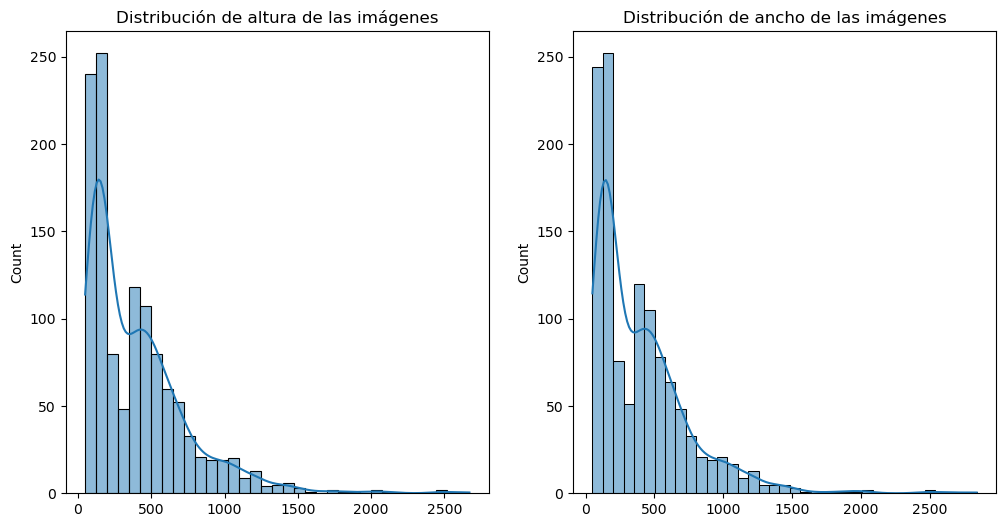

In [23]:
# Dimensiones de las imágenes
image_shapes = []
for category in categorias:
    category_dir = os.path.join(train_dir, category)
    images = os.listdir(category_dir)[:100]  
    for image_name in images:
        image_path = os.path.join(category_dir, image_name)
        img = cv2.imread(image_path)
        if img is not None:
            image_shapes.append(img.shape)


heights = [shape[0] for shape in image_shapes]
widths = [shape[1] for shape in image_shapes]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(heights, kde=True)
plt.title('Distribución de altura de las imágenes')
plt.subplot(1, 2, 2)
sns.histplot(widths, kde=True)
plt.title('Distribución de ancho de las imágenes')
plt.show()

In [19]:
#Configuración del generador de datos para aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalización
    rotation_range=40, #rotación aleatoria
    zoom_range=0.2, #zoom aleatorio
    horizontal_flip=True, #volteo horizontal
    vertical_flip=True, #volteo vertical
    validation_split=0.2 
)

#Generador de datos para entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
#Generador de datos para validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [71]:
#Construcción del modelo
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

#Fine-tuning de las últimas 20 capas
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [73]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape              ┃         Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)     │ (None, 224, 224, 3)       │               0 │ -                         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ rescaling (Rescaling)        │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ normalization                │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]           │
│ (Normalization)              │                           │                 │                           │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ rescaling_1 (Rescaling)      │ (None, 224, 224, 3)       │               0 │ normalization[0][0]       │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ stem_conv_pad                │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]         │
│ (ZeroPadding2D)              │                           │                 │                           │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ stem_conv (Conv2D)           │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]       │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ stem_bn (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]           │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ stem_activation (Activation) │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]             │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ block1a_dwconv               │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]     │
│ (DepthwiseConv2D)            │                           │                 │                           │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ block1a_bn                   │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]      │
│ (BatchNormalization)         │                           │                 │                           │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ block1a_activation           │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]          │
│ (Activation)                 │                           │                 │                           │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ block1a_se_squeeze           │ (None, 32)                │               0 │ block1a_activation[0][0]  │
│ (GlobalAveragePooling2D)     │                           │                 │                           │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ block1a_se_reshape (Reshape) │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]  │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ block1a_se_reduce (Conv2D)   │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]  │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ block1a_se_expand (Conv2D)   │ (None, 1

 Total params: 4,064,943 (15.51 MB)

 Trainable params: 4,022,920 (15.35 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # pérdida de validación para cada 5 épocas se recuperan los mejores pesos
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1) # pérdida de validación  para cada 3 épocas se actualiza el learning rate si no ha mejorado el modelo
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

#Entrenamiento del modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

C:\Users\esco1\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2200 - loss: 2.3093
Epoch 1: val_loss improved from inf to 2.51317, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 1197s 10s/step - accuracy: 0.2213 - loss: 2.3062 - val_accuracy: 0.0465 - val_loss: 2.5132 - learning_rate: 1.0000e-04
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6990 - loss: 0.9680
Epoch 2: val_loss improved from 2.51317 to 2.48114, saving model to best_model.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 1127s 9s/step - accuracy: 0.6994 - loss: 0.9667 - val_accuracy: 0.0539 - val_loss: 2.4811 - learning_rate: 1.0000e-04
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8436 - loss: 0.4712
Epoch 3: val_loss did not improve from 2.48114
119/119 ━━━━━━━━━━━━━━━━━━━━ 1117s 9s/step - accuracy: 0.8437 - loss: 0.4709 - val_accuracy: 0.0507 - val_loss: 2.4999 - learning_rate: 1.0000e-04
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8715 - loss: 0.3759
Epoc

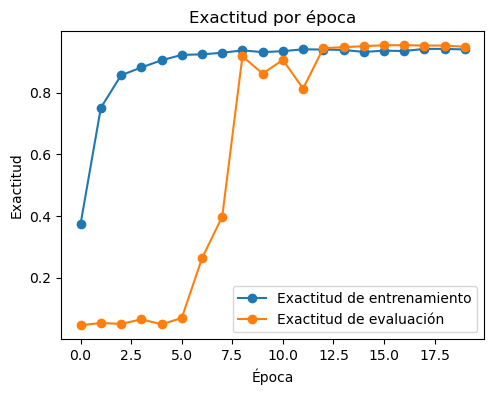

In [91]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Exactitud de entrenamiento', marker='o')
plt.plot(history.history['val_accuracy'], label='Exactitud de evaluación', marker='o')
plt.title('Exactitud por época')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()


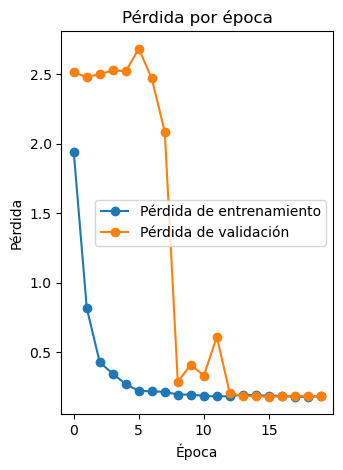

In [93]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento', marker='o')
plt.plot(history.history['val_loss'], label='Pérdida de validación', marker='o')
plt.title('Pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [95]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Pérdida de validación: {val_loss}") # este es pérdida de validaciónval
print(f"Pérdida de entrenamiento: {val_accuracy}") # este es accuracy, no es pérdida.


30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9575 - loss: 0.1655
Pérdida de validación: 0.17703492939472198
Pérdida de entrenamiento: 0.9535374641418457


In [85]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.dirname(test_dir),  
    classes=[os.path.basename(test_dir)], 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 794 images belonging to 1 classes.


In [139]:
from tensorflow.keras.preprocessing import image
import numpy as np

image_filenames = [fname for fname in os.listdir(test_dir) 
                   if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'))]

images = []
for fname in image_filenames:
    img_path = os.path.join(test_dir, fname)
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array /= 255.0  
    images.append(img_array)

images = np.array(images)

predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_labels = [class_labels[class_idx] for class_idx in predicted_classes]

#DataFrame con resultados para subir a Kaggle
results = pd.DataFrame({
    'Archivo': image_filenames,
    'Predicción': predicted_labels
})

print(results)

25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
           Archivo                 Predicción
0    0021e90e4.png  Small-flowered Cranesbill
1    003d61042.png                    Fat Hen
2    007b3da8b.png                 Sugar beet
3    0086a6340.png           Common Chickweed
4    00c47e980.png                 Sugar beet
..             ...                        ...
789  fea355851.png           Loose Silky-bent
790  fea3da57c.png                 Sugar beet
791  fef2ade8c.png                 Sugar beet
792  ff65bc002.png                   Charlock
793  ffc6f8527.png               Common wheat

[794 rows x 2 columns]


30/30 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
Reporte de clasificación:
                           precision    recall  f1-score   support

              Black-grass       0.02      0.02      0.02        52
                 Charlock       0.14      0.14      0.14        78
                 Cleavers       0.11      0.11      0.11        57
         Common Chickweed       0.13      0.13      0.13       122
             Common wheat       0.07      0.07      0.07        44
                  Fat Hen       0.11      0.11      0.11        95
         Loose Silky-bent       0.11      0.12      0.12       130
                    Maize       0.09      0.09      0.09        44
        Scentless Mayweed       0.13      0.14      0.13       103
          Shepherds Purse       0.02      0.02      0.02        46
Small-flowered Cranesbill       0.11      0.11      0.11        99
               Sugar beet       0.07      0.06      0.07        77

                 accuracy                           0.10      

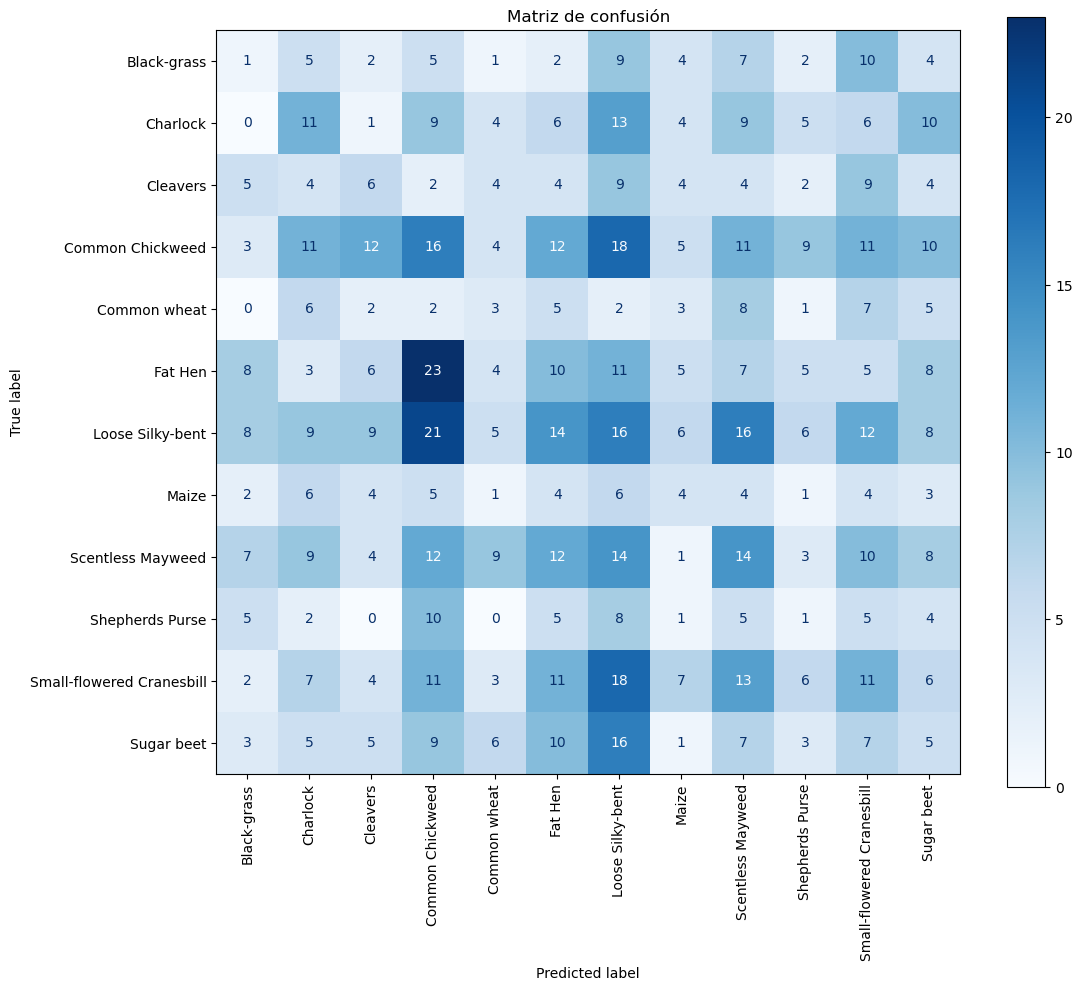

In [140]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
#Realizar evaluación completa
validation_generator.reset()
#Realizar predicciones
Y_true = validation_generator.classes

#Convertir índices a etiquetas
class_indices = validation_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

Y_pred_prob = model.predict(
    validation_generator,
    steps=validation_generator.samples // validation_generator.batch_size + 1,
    verbose=1
)

Y_pred = np.argmax(Y_pred_prob, axis=1)

print("Reporte de clasificación:")
print(classification_report(Y_true, Y_pred, target_names=list(class_labels.values())))

cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_labels.values()))
disp.plot(include_values=True, xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
plt.title('Matriz de confusión')
plt.show()

In [143]:
from sklearn.metrics import precision_score

micro_precision = precision_score(Y_true, Y_pred, average='micro')
print(f"Precisión promediada (micro): {micro_precision:.4f}")
macro_precision = precision_score(Y_true, Y_pred, average='macro')
print(f"Precisión promediada (macro): {macro_precision:.4f}")

weighted_precision = precision_score(Y_true, Y_pred, average='weighted')
print(f"Precisión promediada (ponderada): {weighted_precision:.4f}")

Precisión promediada (micro): 0.1035
Precisión promediada (macro): 0.0928
Precisión promediada (ponderada): 0.1023


In [145]:
from sklearn.metrics import precision_score, f1_score, balanced_accuracy_score

weighted_f1 = f1_score(Y_true, Y_pred, average='weighted')
print(f"F1-Score promediado (ponderado): {weighted_f1:.4f}")

balanced_acc = balanced_accuracy_score(Y_true, Y_pred)
print(f"Exactitud balanceada: {balanced_acc:.4f}")

F1-Score promediado (ponderado): 0.1029
Exactitud balanceada: 0.0932


In [1]:
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')


In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='arquitectura_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.
